In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, LassoCV
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

In [ ]:
# Load data
nba_full_df = pd.read_csv('traditional.csv', parse_dates=['date'])
nba_mvp_df  = pd.read_csv('all.csv', encoding='latin-1')
nba_2025_df = pd.read_csv('PlayerStatistics.csv')

<ipython-input-604-8608c059f3b9>:4: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  nba_2025_df = pd.read_csv('PlayerStatistics.csv')


In [ ]:
# Trimming data to include only data from regular season and the 2000 season and beyond
nba_trimmed = (
    nba_full_df
    .query("type=='regular' and season >= 2000")
)


In [ ]:
# Aggregate per-season, per-player totals for all players
nba_totals = (
    nba_trimmed
    .groupby(['season','playerid','player'])
    [['MIN','PTS','FGM','FGA','FG%','3PM','3PA','3P%',
      'FTM','FTA','FT%','OREB','DREB','REB','AST',
      'STL','BLK','TOV','PF','win','+/-']]
    .sum()
    .reset_index()
)
nba_totals.head()

,season,playerid,player,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,win,+/-
0,2000,3,Grant Long,921,203,74,167,1755.3,0,4,...,86,148,234,43,45,10,49,108,13,-62
1,2000,15,Eric Piatkowski,1717,654,238,573,2942.1,93,243,...,74,148,222,81,44,13,57,140,13,-452
2,2000,21,Greg Anthony,1551,514,169,416,3091.2,88,233,...,17,116,133,208,59,9,85,143,59,207
3,2000,22,Rik Smits,1853,1018,431,890,3828.1,0,1,...,94,307,401,85,20,100,108,249,54,13
4,2000,23,Dennis Rodman,389,34,12,31,270.0,0,1,...,48,123,171,14,2,1,19,41,3,-76


In [ ]:
# Adjusting the new 2025 data
nba_2025_df['gameDate'] = pd.to_datetime(
    nba_2025_df['gameDate'],
    errors='coerce'
)

mask = (
    (nba_2025_df['gameDate'] >= '2024-10-01') &
    (nba_2025_df['gameType'] == 'Regular Season')
)


nba_2025_regular = nba_2025_df.loc[mask].copy()

nba_2025_trimmed = (
    nba_2025_regular
    .groupby(['personId','firstName','lastName'])
    [['numMinutes','points','fieldGoalsMade','fieldGoalsAttempted','fieldGoalsPercentage',
      'threePointersMade','threePointersAttempted','threePointersPercentage',
      'freeThrowsMade','freeThrowsAttempted','freeThrowsPercentage',
      'reboundsOffensive','reboundsDefensive','reboundsTotal','assists',
      'steals','blocks','turnovers','foulsPersonal','plusMinusPoints', 'win']]
    .sum()
    .reset_index()
)

nba_2025_trimmed['player'] = nba_2025_trimmed['firstName'] + ' ' + nba_2025_trimmed['lastName']
nba_2025_trimmed.drop(columns=['firstName','lastName'], inplace=True)

rename_map = {
    'numMinutes': 'MIN','points':'PTS','fieldGoalsMade':'FGM','fieldGoalsAttempted':'FGA',
    'threePointersMade':'3PM','threePointersAttempted':'3PA',
    'freeThrowsMade':'FTM','freeThrowsAttempted':'FTA',
    'reboundsOffensive':'OREB','reboundsDefensive':'DREB','reboundsTotal':'REB',
    'assists':'AST','steals':'STL','blocks':'BLK','turnovers':'TOV',
    'foulsPersonal':'PF','plusMinusPoints':'+/-'
}
nba_2025_trimmed = nba_2025_trimmed.rename(columns=rename_map)

desired_order = [
    'personId','player','MIN','PTS','FGM','FGA','FG%','3PM','3PA','3P%',
    'FTM','FTA','FT%','OREB','DREB','REB','AST','STL','BLK','TOV','PF','win','+/-'
]
nba_2025_trimmed = nba_2025_trimmed[desired_order]

nba_2025_trimmed['season'] = '2025'
nba_2025_trimmed['FG_pct']  = nba_2025_trimmed['FGM'] / nba_2025_trimmed['FGA']
nba_2025_trimmed['3P_pct']  = nba_2025_trimmed['3PM'] / nba_2025_trimmed['3PA']
nba_2025_trimmed['FT_pct']  = nba_2025_trimmed['FTM'] / nba_2025_trimmed['FTA']


In [ ]:
# Getting MVPs per season
df_mvp_labels = (
    nba_mvp_df[nba_mvp_df['Rank'] == 1]
    .loc[:, ['Year','Player']]
    .rename(columns={'Year':'season','Player':'MVP_Player'})
)

In [ ]:
# Merge labels onto full totals
df_labelled = (
    nba_totals
    .merge(df_mvp_labels, on='season', how='left')
)

In [ ]:
# Labeling each mvp season
df_labelled['is_mvp'] = (
    (df_labelled['player'] == df_labelled['MVP_Player'])
    .astype(int)
)

In [ ]:
# Split into features X and target y
df_labelled['FG_pct'] = df_labelled['FGM'] / df_labelled['FGA']
df_labelled['3P_pct'] = df_labelled['3PM'] / df_labelled['3PA']
df_labelled['FT_pct'] = df_labelled['FTM'] / df_labelled['FTA']
drop_feats = ['season','playerid','player','MVP_Player','+/-','is_mvp','FG%','3P%','FT%']
X_all = df_labelled.drop(columns=drop_feats)
y_all = df_labelled['is_mvp'].values
feature_names = X_all.columns.tolist()
X_all = X_all.values

In [ ]:
# Splitting the training and testing
test_year  = 2024
window_years = 10
mask_test   = df_labelled['season'] == test_year
mask_train  = df_labelled['season'].between(test_year-window_years, test_year-1)

X_train, y_train = X_all[mask_train], y_all[mask_train]
X_test,  y_test  = X_all[mask_test], y_all[mask_test ]

feature_cols = df_labelled.drop(columns=drop_feats).columns.tolist()

drop_feats = ['is_mvp', 'season','playerid','player','MVP_Player', 'PF', '+/-', 'TOV']


X_all = df_labelled[feature_cols].values


In [ ]:
# seperate code for 2025
feature_cols = ['MIN','PTS','FGM','FGA','3PM','3PA','FTM','FTA','OREB','DREB','REB',
                'AST','STL','BLK','TOV','PF','win','FG_pct','3P_pct','FT_pct']


mask_train = df_labelled['season'].between(2013, 2024)
X_train = df_labelled.loc[mask_train, feature_cols].values
y_train = df_labelled.loc[mask_train, 'is_mvp'].values

scaler = StandardScaler().fit(X_train)
imp = SimpleImputer(strategy='median').fit(scaler.transform(X_train))
X_train_imp = imp.transform(scaler.transform(X_train))
rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_features=0.3)
rf_clf.fit(X_train_imp, y_train)
print("RF trained on seasons 2015–2019.")

X_2025 = nba_2025_trimmed[feature_cols].values
X_2025_imp = imp.transform(scaler.transform(X_2025))
probs_2025 = rf_clf.predict_proba(X_2025_imp)[:,1]
results_2025 = nba_2025_trimmed[['player']].copy()
results_2025['MVP_Prob'] = probs_2025
predicted_2025 = results_2025.sort_values('MVP_Prob', ascending=False).reset_index(drop=True)
print("Predicted 2025 MVP ranking:\n", predicted_2025)

RF trained on seasons 2015–2019.
Predicted 2025 MVP ranking:
                       player  MVP_Prob
0               Nikola Jokic     0.240
1    Shai Gilgeous-Alexander     0.200
2               Jayson Tatum     0.060
3            Anthony Edwards     0.040
4               James Harden     0.015
..                       ...       ...
574             Drew Eubanks     0.000
575        Haywood Highsmith     0.000
576              Amir Coffey     0.000
577          DaQuan Jeffries     0.000
578             Jack McVeigh     0.000

[579 rows x 2 columns]


In [ ]:
# Scaling the data
scaler = StandardScaler().fit(X_train)
X_tr_s = scaler.transform(X_train)
X_te_s = scaler.transform(X_test)

imp = SimpleImputer(strategy='median')
X_tr_s = imp.fit_transform(X_tr_s)
X_te_s = imp.transform(X_te_s)

decay = 0.5
season_diffs = test_year - df_labelled.loc[mask_train, 'season']
sample_weights = np.exp(-decay * season_diffs.values)

In [ ]:
# Training and evaluating
def train_random_forest(X_train, y_train, **kwargs):
    rf = RandomForestClassifier(**kwargs)
    rf.fit(X_train, y_train)
    return rf


def evaluate_ridge(X_train, y_train, X_test, y_test, alpha=1.0):
    rd = Ridge(alpha=alpha)
    rd.fit(X_train, y_train)
    return rd.score(X_test, y_test)


def get_top10_features(model, feature_names):
    importances = pd.Series(model.feature_importances_, index=feature_names)
    return importances.sort_values(ascending=False).head(10)

In [ ]:
rf_clf     = RandomForestClassifier(
               n_estimators=200,
               class_weight='balanced',
               max_features=0.3,
             ).fit(X_tr_s, y_train)

In [ ]:
probs = rf_clf.predict_proba(X_te_s)[:,1]            # use X_te_s, not X_te_scaled
results = df_labelled.loc[mask_test, ['player']].copy()
results['MVP_Prob'] = probs
evaluated = results.sort_values('MVP_Prob', ascending=False).reset_index(drop=True)
print(f"Predicted MVP ranking for {test_year}:\n", evaluated)

# RandomForest accuracy on test set
rf_acc = accuracy_score(y_test, rf_clf.predict(X_te_s))
print(f"RandomForest accuracy on {test_year}: {rf_acc:.4f}")

# Re-compute Ridge R² before printing
ridge_r2 = evaluate_ridge(X_tr_s, y_train, X_te_s, y_test)
print(f"Ridge Regression R² on {test_year}: {ridge_r2:.4f}")

Predicted MVP ranking for 2024:
                       player  MVP_Prob
0                Luka Doncic     0.270
1      Giannis Antetokounmpo     0.160
2    Shai Gilgeous-Alexander     0.105
3               Nikola Jokic     0.070
4            Anthony Edwards     0.040
..                       ...       ...
567              P.J. Tucker     0.000
568               Kyle Lowry     0.000
569               Chris Paul     0.000
570           Malik Williams     0.000
571         Danilo Gallinari     0.000

[572 rows x 2 columns]
RandomForest accuracy on 2024: 1.0000
Ridge Regression R² on 2024: 0.0000


Top 10 feature importances:
PTS    0.264234
TOV    0.207235
FGM    0.150164
FGA    0.111885
FTM    0.073155
win    0.050192
FTA    0.045281
3PA    0.030308
STL    0.020814
MIN    0.018437
dtype: float64


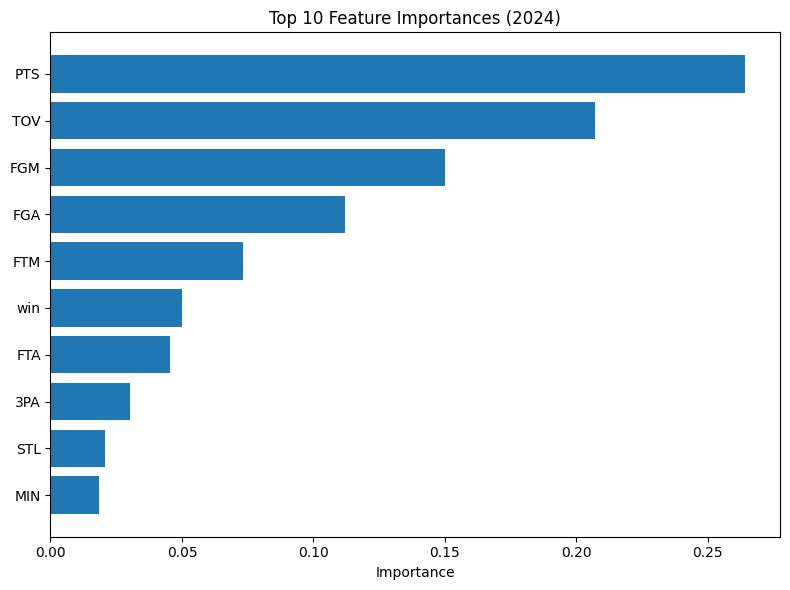

In [ ]:
top10 = get_top10_features(rf_clf, feature_cols)
print("Top 10 feature importances:")
print(top10)

plt.figure(figsize=(8,6))
plt.barh(top10.index[::-1], top10.values[::-1])
plt.xlabel('Importance')
plt.title(f'Top 10 Feature Importances ({test_year})')
plt.tight_layout()
plt.show()

In [ ]:
imp       = SimpleImputer(strategy='median')
X_all_imp = imp.fit_transform(X_all)

kf      = KFold(n_splits=5, shuffle=True, random_state=42)
logreg  = LogisticRegression(max_iter=10000)
scores  = cross_val_score(logreg,
                          X_all_imp,
                          y_all,
                          cv=kf,
                          scoring='accuracy')
print("5-fold LogisticRegression accuracy:", scores)
print("Mean accuracy:", scores.mean())

5-fold LogisticRegression accuracy: [0.99876033 0.99752066 0.99876033 0.99834642 0.99958661]
Mean accuracy: 0.9985948704983617
